### 注意力机制
![](img/2022-05-18-11-03-37.png)

### 注意力的可视化
平均汇聚层可以视为输入的加权平均,各个输入的权重是相同的.实际上,注意力汇聚得到的是加权平均的总和,权重是给定的query和不同的key之间计算得出的.

In [1]:
import torch
from torch import nn as nn
import sys,os
sys.path.append(os.path.abspath("../"))
import lmy
from lmy import show_heatmaps
import d2l


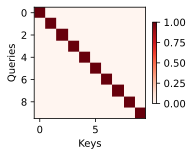

In [2]:
attention_weights = torch.eye(10).reshape((1,1,10,10))
show_heatmaps(attention_weights,xlabel='Keys',ylabel='Queries')

### 注意力汇聚(Attention Pooling):Nadaraya-Watson核回归
注意力汇聚有选择地聚合了值(感官输入)以生成最终的输出.
本节介绍64年提出的Nadaraya-Watson核回归模型

#### 生成数据集
考虑回归问题:给定成对的"输入-输出"数据集{(x1,y1),....{xn,yn}},如何学习f来预测任意新输入x的输出$\hat{y} = f(x)$

根据下面的非线性函数生成一个人工数据集 并加入噪声$\epsilon$(服从0,.5的正态分布)
$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

In [24]:
num_train = 50
torch.manual_seed(0)
# torch.cuda.manual_seed_all(0)
x_train, indices = torch.sort(torch.rand(num_train)*5)

def f(x):
    return 2*torch.sin(x)+x**.8

ep = torch.normal(0,.5,(num_train,))
y_train = f(x_train)+ep

x_test = torch.arange(0,5,.1) 
y_label = f(x_test)
num_test = len(x_test)

In [25]:
def plot_kernel_reg(y_hat):
    # 将真实的标签和预测的标签画在一起
    d2l.plot(x_test, [y_label, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, '.', alpha=0.5)

### 使用平均汇聚层

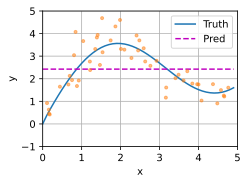

In [26]:
y_Pred = torch.repeat_interleave(y_train.mean(),num_test)
plot_kernel_reg(y_Pred)
# y_hat

### 非参数的注意力汇聚

明显,平均池化不受自变量x的影响, Nadaraya和Watson提出了更好的想法,根据输入位置对输出$y_i$进行加权.公式如下
$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$
其中K是核Kernel,公式所描述的估计器被称为Nadaraya-Watson kernel regression
这里不讨论K的细节,看得出来 K反应了当前的权重, 通过注意力机制框架的角度对公式进行重写,获得通用注意力汇聚(Attention Pooling)公式:
$$
f(x)= \sum_{i=1}^n \alpha(x,x_i)y_i
$$
其中x是查询,(xi,yi)是键值对. 这里将查询x和键xi之间的关系建模为 注意力权重$\alpha(x,x_i)$,这个权重将分配各每一个对应值yi.

**高斯核函数Gaussian Kernel**
$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})
$$
将高斯核代入可得
$$
\begin{split}
\begin{aligned} 
f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i
\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{(x - x_i)^2}{2}\right)}{\sum_{j=1}^n \exp\left(-\frac{(x - x_j)^2}{2}\right)}y_i 
\\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{(x - x_i)^2}{2}\right) y_i. 
\end{aligned}
\end{split}
$$

公式中当一个查询x越接近于键xi,其权值越大,即"获取了更多的注意力"
值得注意的是,NW核回归是一个非参数模型.因此上述狮子是非参数的(无需学习的)注意力汇聚模型

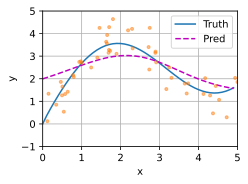

In [6]:
X_repeat = x_test.repeat_interleave(num_train).reshape((-1,num_train))
X_repeat
attention_weights = torch.nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
y_hat = torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

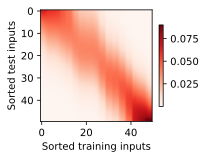

In [7]:
x=attention_weights.unsqueeze(0).unsqueeze(0)
show_heatmaps(x,xlabel='Sorted training inputs',
              ylabel='Sorted test inputs')
# 这里测试数据相当于query,而训练数据相当于key,两个输出通过排序后,因此可知"q-k"对越来越接近,注意力汇聚的权重就越高

### 带参数的注意力汇聚
非参数的NW核回归具有一致性(consistency)的优点:如果有足量的数据,此模型会收敛到最优.尽管如此,我们还是可以轻松地将参数集成到注意力汇聚中.\
**将距离乘以一个科学系的参数$w$**
$$
f(x) = \sum_{i=1}^n \mathrm{softmax}\left(-\frac{\left((x-x_i)w\right)^2}{2}\right)y_i
$$


#### 批量矩阵乘法
为了更有效地计算小批量数据的注意力,我们可以利用深度学习开发框架中提供的批量矩阵乘法.
假设第一个小批量数据包含n个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$,形状为a*b,

第二个小批量包含n个矩阵$\mathbf{Y}_1,\ldots,\mathbf{Y}_n$,形状为b*c,

矩阵的批量乘法得到n个矩阵$\mathbf{X}_1{Y}_1,\ldots, \mathbf{X}_n{Y}_n$,形状为a*c.
因此假定两个张量的形状分别为(n,a,b)和(n,b,c) 得到批量矩阵乘法输出为(n,a,c)

In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape# batch matrix-matrix 


torch.Size([2, 1, 6])

In [9]:
weights = torch.ones((2,10))*.01
values = torch.arange(20.0).reshape((2,10))
weights,values,torch.bmm(weights.unsqueeze(1),values.unsqueeze(-1))

(tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100]]),
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]]),
 tensor([[[0.4500]],
 
         [[1.4500]]]))

### 模型的定义

In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,)),requires_grad=True)
    
    def forward(self,queries,keys,values):
        # queries和权重的shape 是(查询个数,键值对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries-keys)*self.w)**2/2,dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

In [11]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((num_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((num_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(num_train)).type(torch.bool)].reshape((num_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(num_train)).type(torch.bool)].reshape((num_train, -1))

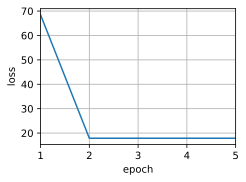

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

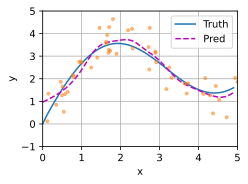

In [13]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((num_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((num_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

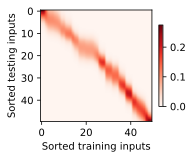

In [14]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')